I changed some codes and rest of codes are same as 
"Introduction to Ensembling/Stacking in Python" notebook by Anisotropic
https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python/notebook

but KFold is moved to model_selection in scikit learn and I encountered a few errors about this.
While I copying the notebook, I decided to turn this notebook to public for beginner.

* import 
> from sklearn.model_selection import KFold
* n_split -> n_splits
* kf.split
* get_oof
> def feature_importances(self,x,y):<br>
>         return self.clf.fit(x,y).feature_importances_
        
* feature_importances
> rf_features=list(rf.feature_importances(x_train,y_train)) 
<br>
+)And some more details 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold
# from sklearn.cross_validation import KFold

In [3]:
train=pd.read_csv('/kaggle/input/titanic/train.csv')
test=pd.read_csv('/kaggle/input/titanic/test.csv')

PassengerId=test['PassengerId']
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
PassengerId

0       892
1       893
2       894
3       895
4       896
       ... 
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64

# Feature Exploration

In [5]:
print(type(train['Cabin'].iloc[0]))

<class 'float'>


In [6]:
full_data=[train,test]
train['Name_length']=train['Name'].apply(len)
test['Name_length']=test['Name'].apply(len)

#type(train['Cabin'].iloc[0]) ==> float
train['Has_Cabin']=train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin']=test['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

for dataset in full_data:
    dataset['FamilySize']=dataset['SibSp']+dataset['Parch']+1

for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] ==1, 'IsAlone']=1
    
for dataset in full_data:
    dataset['Embarked']=dataset['Embarked'].fillna('S')
    
for dataset in full_data:
    dataset['Fare']=dataset['Fare'].fillna(train['Fare'].median())
    
train['CategoricalFare']=pd.qcut(train['Fare'], 4)

for dataset in full_data:
    age_avg=dataset['Age'].mean()
    age_std=dataset['Age'].std()
    age_null_count=dataset['Age'].isnull().sum()
    age_null_random_list=np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])]=age_null_random_list
    dataset['Age']=dataset['Age'].astype(int)
    
train['CategoricalAge']=pd.cut(train['Age'],5)

In [7]:
def get_title(name):
    title_search=re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""
for dataset in full_data:
    dataset['Title']=dataset['Name'].apply(get_title)
    
for dataset in full_data:
    dataset['Title']=dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'],'Rare')

dataset['Title']=dataset['Title'].replace('Mlle', 'Miss')
dataset['Title']=dataset['Title'].replace('Ms', 'Miss')
dataset['Title']=dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    dataset['Sex']=dataset['Sex'].map({'female':int(0), 'male':int(1)})
#     dataset['Sex']=dataset['Sex'].map({'female':0, 'male':1})
#     dataset['Sex']=dataset['Sex'].astype(int)
    title_mapping={'Mr':1, 'Miss':2, 'Mrs':3,'Master':4, 'Rare':5}
    dataset['Title']=dataset['Title'].map(title_mapping)
    dataset['Title']=dataset['Title'].fillna(0)
    dataset['Embarked']=dataset['Embarked'].map({'S':0,'C':1,'Q':2}).astype(int)
    
    dataset.loc[dataset['Fare']<=7.91, 'Fare']=0
    dataset.loc[(dataset['Fare']>7.91) & (dataset['Fare']<=14.454), 'Fare']=1
    dataset.loc[(dataset['Fare']>14.454) & (dataset['Fare']<=31), 'Fare']=2
    dataset.loc[(dataset['Fare']>31),'Fare']=3
    dataset['Fare']=dataset['Fare'].astype(int)
    
    dataset.loc[dataset['Age']<=16,'Age']=0
    dataset.loc[(dataset['Age'])>16 & (dataset['Age']<=32), 'Age']=1
    dataset.loc[(dataset['Age'])>32 & (dataset['Age']<=48), 'Age']=2
    dataset.loc[(dataset['Age'])>48 & (dataset['Age']<=64), 'Age']=3
    dataset.loc[(dataset['Age'])>64, 'Age']=4

In [8]:
drop_elements=['PassengerId','Name','Ticket','Cabin', 'SibSp']
train=train.drop(drop_elements,axis=1)
train=train.drop(['CategoricalAge', 'CategoricalFare'],axis=1)
test=test.drop(drop_elements, axis=1)

In [9]:
train.head(10)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,3,0,0,0,23,0,2,0,1.0
1,1,1,0,3,0,3,1,51,1,2,0,3.0
2,1,3,0,3,0,1,0,22,0,1,1,2.0
3,1,1,0,3,0,3,0,44,1,2,0,3.0
4,0,3,1,3,0,1,0,24,0,1,1,1.0
5,0,3,1,3,0,1,2,16,0,1,1,1.0
6,0,1,1,3,0,3,0,23,1,1,1,1.0
7,0,3,1,0,1,2,0,30,0,5,0,4.0
8,1,3,0,3,2,1,0,49,0,3,0,3.0
9,1,2,0,0,0,2,1,35,0,2,0,3.0


## visualization

Pearson Correlation plot

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

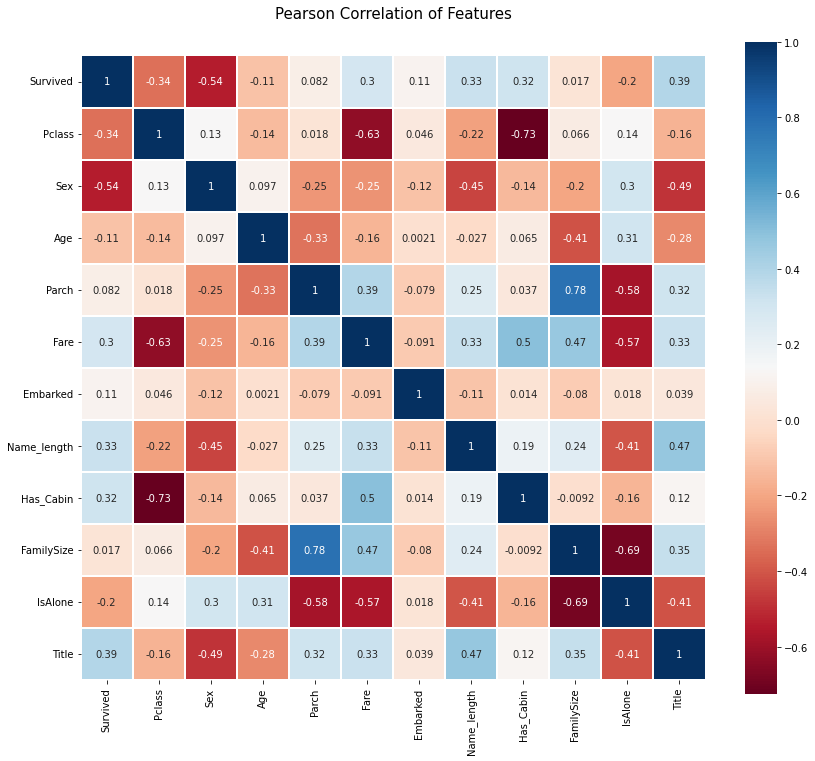

In [10]:
colormap=plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0,square=True, cmap=colormap, linecolor='white', annot=True)

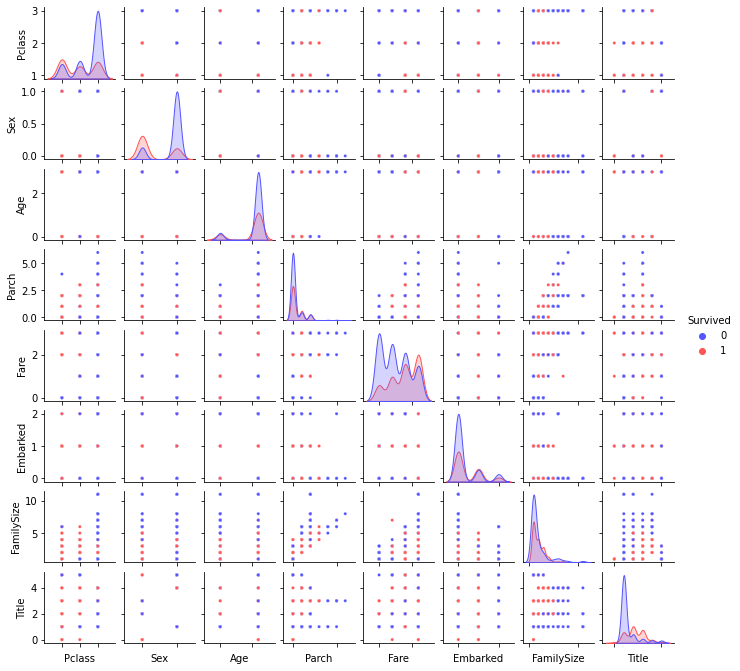

In [11]:
g= sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title']], hue='Survived', palette='seismic', size=1.2, diag_kind='kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))
g.set(xticklabels=[])

# Ensembel stacking model

In [12]:
ntrain=train.shape[0]
ntest=test.shape[0]
SEED=0
NFOLDS=5

#sklearn의 kfold가 cross_validation 에서 model selection 껄로 옮겨지면서 n_folds가 n_splits로 달라짐
# kf=KFold(ntrain, n_folds=NFOLDS, random_state=SEED)
kf = KFold(n_splits= NFOLDS, random_state=SEED)

In [13]:
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state']=seed
        self.clf= clf(**params)
    
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    def predict(self, x):
        return self.clf.predict(x)
    def fit(self, x,y):
        return self.clf.fit(x,y)
    def feature_importances(self,x,y):
        return self.clf.fit(x,y).feature_importances_

## Out-of-Fold Predictions

서론에서 말한 것과 같이, 2레벨의 예측을 사용

In [14]:
def get_oof(clf, x_train,y_train, x_test):
    oof_train=np.zeros((ntrain,))
    oof_test=np.zeros((ntest,))
    oof_test_skf=np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf.split(train)):
        x_tr=x_train[train_index]
        y_tr=y_train[train_index]
        x_te=x_train[test_index]
        
        clf.train(x_tr, y_tr)
        
        oof_train[test_index]=clf.predict(x_te)
        oof_test_skf[i,:]=clf.predict(x_test)
        
    oof_test[:]=oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1,1),oof_test.reshape(-1,1)

In [15]:
#random forest 파라미터
rf_params={'n_jobs':-1,
          'n_estimators':500,
          'warm_start':True,
          'max_depth':6,
          'min_samples_leaf':2,
          'max_features':'sqrt',
          'verbose':0}

#extra tree 파라미터
et_params={
    'n_jobs':-1,
    'n_estimators':500,
    'max_depth':8,
    'min_samples_leaf':2,
    'verbose':0}

#adaboost 파라미터
ada_params={'n_estimators':500,
           'learning_rate':0.75}

#Gradient boosting 파라미터
gb_params={'n_estimators':500,
          'max_depth':5,
          'min_samples_leaf':2,
          'verbose':0}

# support vector machine 파라미터
svm_params={'kernel':'linear',
           'C':0.025}

In [16]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et= SklearnHelper(clf=ExtraTreesClassifier, seed= SEED, params=et_params)
ada=SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb=SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc=SklearnHelper(clf=SVC, seed=SEED, params=svm_params)

In [17]:
#numpy 로 바꾼다
y_train=train['Survived'].ravel()
train=train.drop(['Survived'],axis=1)
x_train=train.values
x_test=test.values

## output of first level predictions

1 level classifier

In [18]:
rf_oof_train, rf_oof_test=get_oof(rf, x_train,y_train, x_test)
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test)
ada_oof_train, ada_oof_test=get_oof(ada, x_train,y_train, x_test)
gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test)
svc_oof_train, svc_oof_test=get_oof(svc, x_train,y_train, x_test)

print("training is completed")

training is completed


In [19]:
rf_features=list(rf.feature_importances(x_train,y_train))
et_features=list(et.feature_importances(x_train,y_train))
ada_features=list(ada.feature_importances(x_train,y_train))
gb_features=list(gb.feature_importances(x_train,y_train))

In [20]:
cols=train.columns.values

feature_dataframe=pd.DataFrame(
    {
        'features':cols,
        'Random Forest feature importances': rf_features,
        'Extra Trees feature importances':et_features,
        'Adaboost feature importances':ada_features,
        'Gradient Boost feature importances':gb_features
    })

### Random Forest

In [21]:
trace=go.Scatter(
    y=feature_dataframe['Random Forest feature importances'].values,
    x=feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode='diameter',
        sizeref=1,
        size = 25,
        color=feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True),
    text=feature_dataframe['features'].values
)

data=[trace]

layout=go.Layout(
    autosize=True,
    title='Random Forest Feature Importance',
    hovermode='closest',
    yaxis=dict(
        title='Feature Importance',
        ticklen=5,
        gridwidth=2),
    showlegend=False
)
fig=go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

### Extra trees

In [22]:
trace = go.Scatter(
    y = feature_dataframe['Extra Trees feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Extra Trees feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees feature importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

### Adaboost

In [23]:
trace = go.Scatter(
    y = feature_dataframe['Adaboost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Adaboost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

### Gradient Boosting

In [24]:
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [25]:
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,Adaboost feature importances,Gradient Boost feature importances
0,Pclass,0.126925,0.123939,0.032,0.114562
1,Sex,0.214885,0.402909,0.008,0.276929
2,Age,0.016306,0.029478,0.006,0.024540


In [26]:
feature_dataframe['mean'] = feature_dataframe.mean(axis=1)
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,Adaboost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.126925,0.123939,0.032,0.114562,0.099356
1,Sex,0.214885,0.402909,0.008,0.276929,0.225681
2,Age,0.016306,0.029478,0.006,0.024540,0.019081


In [27]:
y=feature_dataframe['mean'].values
x=feature_dataframe['features'].values
data=[go.Bar(x=x, y=y, width=0.5, marker=dict(color=feature_dataframe['mean'].values,
                                             colorscale='Portland',
                                             showscale=True,
                                             reversescale=False),
            opacity=0.6)]

layout=go.Layout(
autosize=True,
title='Barplots of Mean Feature Importance',
hovermode='closest',
yaxis=dict(title='Feature Importance',
          ticklen=5,
          gridwidth=2),
showlegend=False)

fig=go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

# Second-level Predictions from the first-level output

### First-level output as new features

In [28]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
                                       'ExtraTrees': et_oof_train.ravel(),
                                       'AdaBoost': ada_oof_train.ravel(),
                                       'GradientBoost':gb_oof_train.ravel()})
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


### Correlation Heatmap of the Second Level Training set

In [29]:
data = [
    go.Heatmap(
    z=base_predictions_train.astype(float).corr().values,
    x=base_predictions_train.columns.values,
    y=base_predictions_train.columns.values,
    colorscale='Viridis',
    showscale=True,
    reversescale=True)
]
py.iplot(data, filename='labelled-heatmap')

In [30]:
x_train=np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train,svc_oof_train), axis=1)
x_test= np.concatenate((et_oof_test, rf_oof_test, ada_oof_test,gb_oof_test, svc_oof_test), axis=1)

In [31]:
et_oof_train[:10]

array([[0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.]])

In [32]:
x_train[:3]

array([[0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1.]])

### Second level learning model via XGBoost

In [33]:
gbm = xgb.XGBClassifier(
    n_estimators=2000,
    max_depth=4,
    min_child_weight=2,
    gamma=0.9,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=-1,
    scale_pos_weight=1).fit(x_train, y_train)

predictions=gbm.predict(x_test)

[11:58:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [34]:
StackingSubmission=pd.DataFrame({'PassengerId': PassengerId,
                                'Survived': predictions})
StackingSubmission.to_csv("StackingSubmission.csv",index=False)